#Hollywood Age Gap - Primary Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# 0) Load + clean + derived fields
df = pd.read_csv("https://raw.githubusercontent.com/patelparisha/ba820-b1-team10/EDA/age_gaps.csv")


# Target variable: age gap (in years)
df["age_gap"] = pd.to_numeric(df["age_difference"], errors="coerce")

# Keep only rows with valid year + age gap
df = df.dropna(subset=["release_year", "age_gap"]).copy()
df["release_year"] = df["release_year"].astype(int)

# Always create a baseline-adjusted time column (prevents formula errors)
BASE_YEAR = int(df["release_year"].min())
df["years_since_start"] = df["release_year"] - BASE_YEAR

# Decade bucket for time-based aggregation
df["decade"] = (df["release_year"] // 10) * 10

# Couple type label (used for couple-type comparisons)
df["pairing_type"] = (
    df["character_1_gender"].astype(str).str.strip().str.lower()
    + "–" +
    df["character_2_gender"].astype(str).str.strip().str.lower()
)

# Gender of older partner (actor_1 is older by dataset construction)
df["older_partner_gender"] = (
    df["character_1_gender"].astype(str).str.strip().str.title()
)

# Movie-level grouping key (movie + year)
movie_key = ["movie_name", "release_year"]

# Thresholds for interpretable summaries
LARGE_GAP = 20
PARITY_CUTOFF = 3

df["is_large_gap"] = df["age_gap"] >= LARGE_GAP
df["is_near_parity"] = df["age_gap"] <= PARITY_CUTOFF

df.head()


,movie_name,release_year,director,age_difference,couple_number,actor_1_name,actor_2_name,character_1_gender,character_2_gender,actor_1_birthdate,actor_2_birthdate,actor_1_age,actor_2_age,age_gap,years_since_start,decade,pairing_type,older_partner_gender,is_large_gap,is_near_parity
0,Harold and Maude,1971,Hal Ashby,52,1,Ruth Gordon,Bud Cort,woman,man,1896-10-30,1948-03-29,75,23,52,36,1970,woman–man,Woman,True,False
1,Venus,2006,Roger Michell,50,1,Peter O'Toole,Jodie Whittaker,man,woman,1932-08-02,1982-06-03,74,24,50,71,2000,man–woman,Man,True,False
2,The Quiet American,2002,Phillip Noyce,49,1,Michael Caine,Do Thi Hai Yen,man,woman,1933-03-14,1982-10-01,69,20,49,67,2000,man–woman,Man,True,False
3,The Big Lebowski,1998,Joel Coen,45,1,David Huddleston,Tara Reid,man,woman,1930-09-17,1975-11-08,68,23,45,63,1990,man–woman,Man,True,False
4,Beginners,2010,Mike Mills,43,1,Christopher Plummer,Goran Visnjic,man,man,1929-12-13,1972-09-09,81,38,43,75,2010,man–man,Man,True,False


# Understanding the data through charts and plots
(Quick baseline EDA: distributions, central tendency, imbalance, outliers)

### 1) Central tendency + spread (mean/median/mode/std) for age_gap

In [3]:

age_gap_series = df["age_gap"].dropna()

central_stats = pd.DataFrame({
    "metric": ["count", "mean", "median", "mode", "std", "min", "max", "q25", "q75"],
    "value": [
        age_gap_series.size,
        age_gap_series.mean(),
        age_gap_series.median(),
        age_gap_series.mode().iloc[0] if not age_gap_series.mode().empty else np.nan,
        age_gap_series.std(),
        age_gap_series.min(),
        age_gap_series.max(),
        age_gap_series.quantile(0.25),
        age_gap_series.quantile(0.75),
    ]
})
central_stats["value"] = central_stats["value"].round(3)

print("\nBaseline stats for age_gap:")
display(central_stats)


Baseline stats for age_gap:


,metric,value
0,count,1155.000
1,mean,10.424
2,median,8.000
3,mode,2.000
4,std,8.511
5,min,0.000
6,max,52.000
7,q25,4.000
8,q75,15.000


##2) Histogram of age_gap (overall distribution + tail behavior)

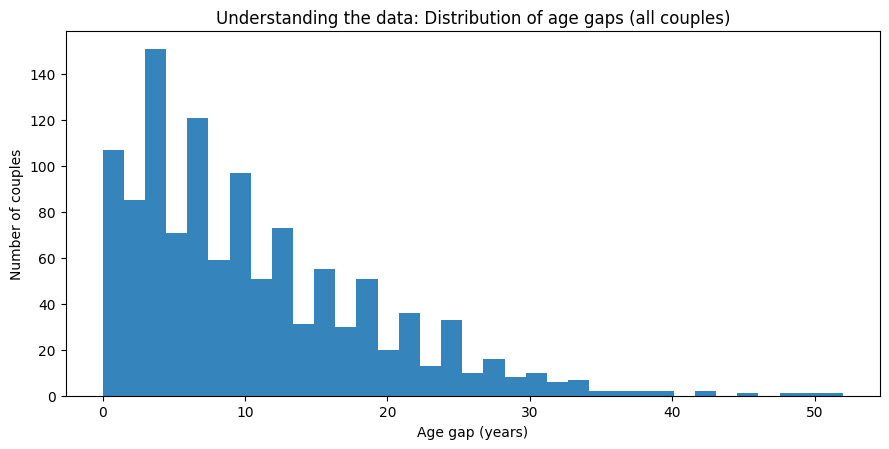

In [4]:
fig, ax = plt.subplots(figsize=(9, 4.6))
ax.hist(age_gap_series, bins=35, alpha=0.90)
ax.set_title("Understanding the data: Distribution of age gaps (all couples)")
ax.set_xlabel("Age gap (years)")
ax.set_ylabel("Number of couples")
plt.tight_layout()
plt.show()

##3) Boxplot of age_gap (outliers/extreme cases)

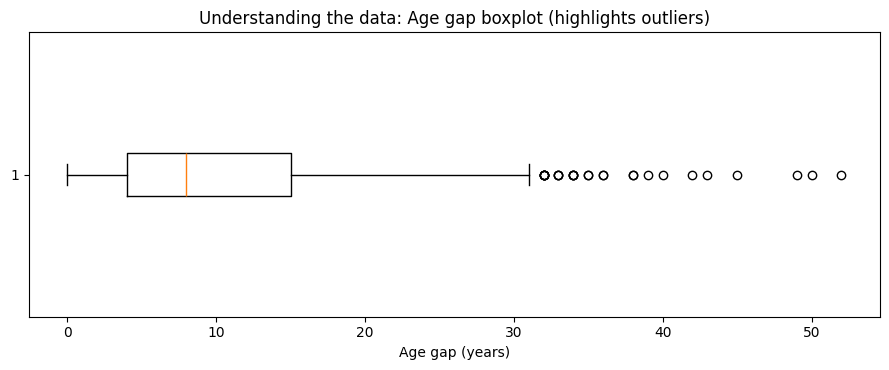

In [5]:
fig, ax = plt.subplots(figsize=(9, 3.8))
ax.boxplot(age_gap_series.values, vert=False, showfliers=True)
ax.set_title("Understanding the data: Age gap boxplot (highlights outliers)")
ax.set_xlabel("Age gap (years)")
plt.tight_layout()
plt.show()

##4) Release year distribution (data imbalance over time)

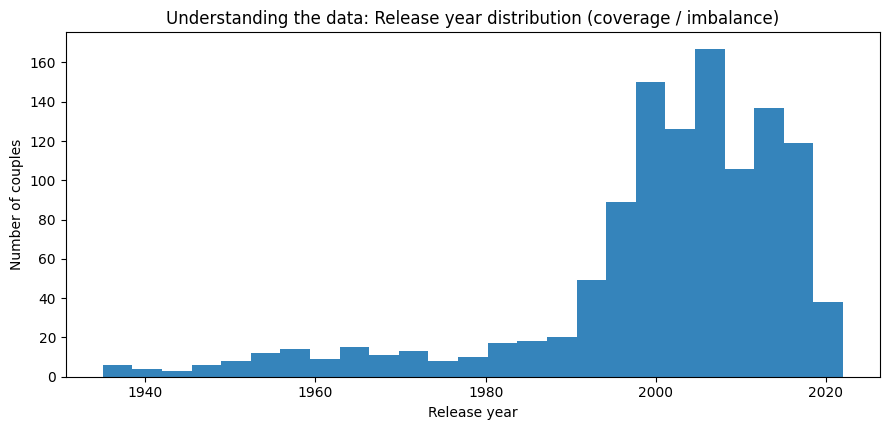

In [6]:
fig, ax = plt.subplots(figsize=(9, 4.4))
ax.hist(df["release_year"], bins=25, alpha=0.90)
ax.set_title("Understanding the data: Release year distribution (coverage / imbalance)")
ax.set_xlabel("Release year")
ax.set_ylabel("Number of couples")
plt.tight_layout()
plt.show()

##5) Couples per movie (does the dataset contain many multi-couple movies?)

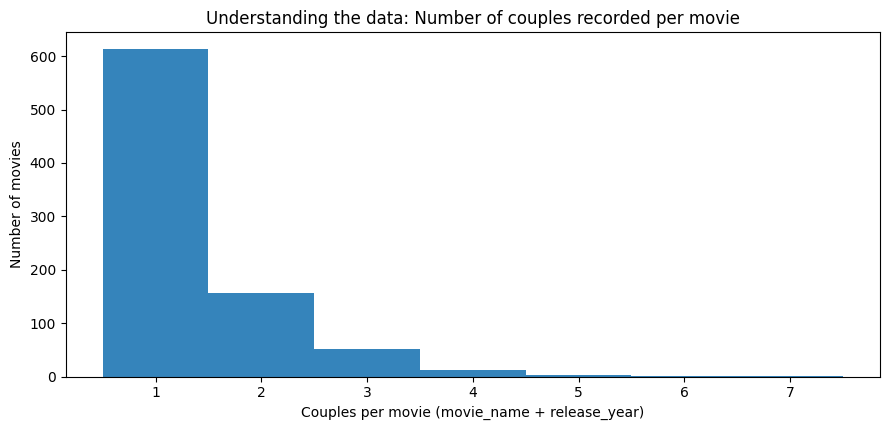

In [7]:
couples_per_movie = df.groupby(movie_key).size()

fig, ax = plt.subplots(figsize=(9, 4.4))
ax.hist(couples_per_movie, bins=range(1, int(couples_per_movie.max()) + 2), alpha=0.90, align="left")
ax.set_title("Understanding the data: Number of couples recorded per movie")
ax.set_xlabel("Couples per movie (movie_name + release_year)")
ax.set_ylabel("Number of movies")
plt.tight_layout()
plt.show()

##6) Couple-type imbalance (how much is mixed vs same-gender)


Couple type counts (shows representation imbalance):


,pairing_type,count
0,man–woman,929
1,woman–man,203
2,man–man,12
3,woman–woman,11


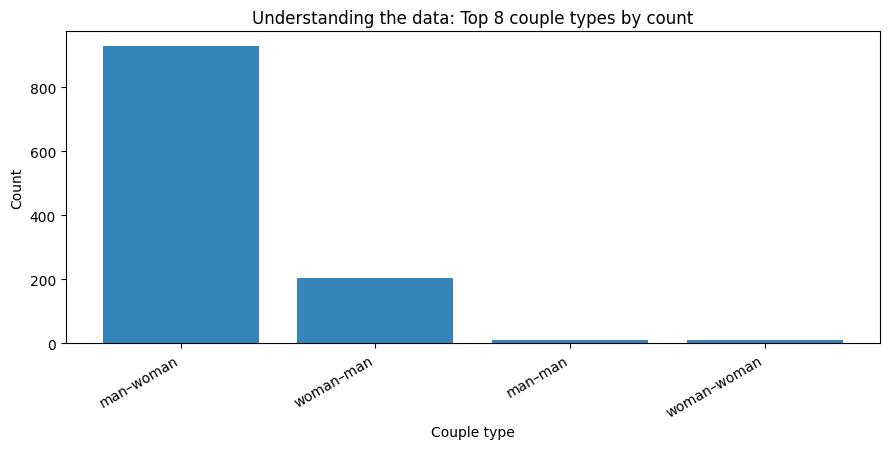

In [8]:
type_counts = (
    df["pairing_type"]
    .value_counts()
    .rename_axis("pairing_type")
    .reset_index(name="count")
)

print("\nCouple type counts (shows representation imbalance):")
display(type_counts)

# Plot the top couple types for readability
top_n = 8
top_types = type_counts.head(top_n)

fig, ax = plt.subplots(figsize=(9, 4.6))
ax.bar(top_types["pairing_type"], top_types["count"], alpha=0.90)
ax.set_title(f"Understanding the data: Top {top_n} couple types by count")
ax.set_xlabel("Couple type")
ax.set_ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

##7) Quick check: age_gap vs release_year (scatter only; trend added later in Q1)

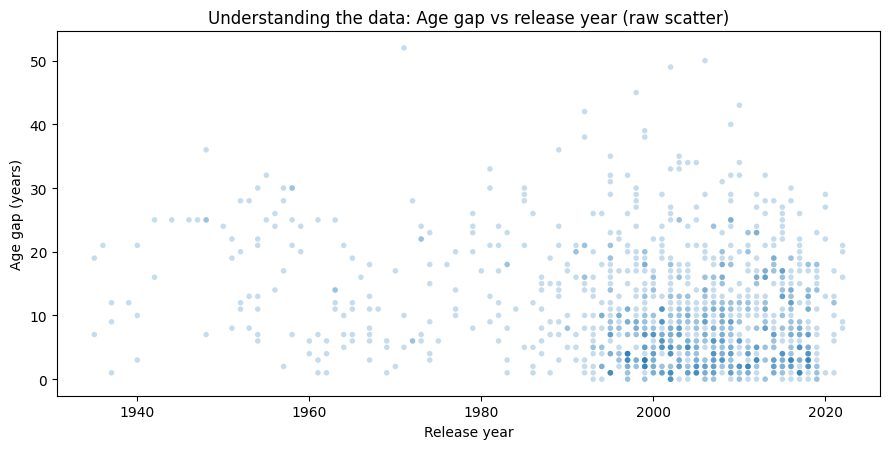

In [9]:
fig, ax = plt.subplots(figsize=(9, 4.6))
ax.scatter(df["release_year"], df["age_gap"], s=16, alpha=0.25, edgecolors="none")
ax.set_title("Understanding the data: Age gap vs release year (raw scatter)")
ax.set_xlabel("Release year")
ax.set_ylabel("Age gap (years)")
plt.tight_layout()
plt.show()

#Chart Configuration

In [10]:
plt.rcParams.update({
    "figure.dpi": 140,
    "axes.facecolor": "#f2f2f2",
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.color": "white",
    "grid.linewidth": 1.0,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
})


def add_regression_with_ci(
    ax,
    data,
    xcol_year,
    ycol,
    formula,
    *,
    point_alpha=0.25,
    point_size=18,
    line_width=2.6,
    ci_alpha=0.22
):
    """
    Draw a clean scatterplot with:
      - OLS regression line
      - 95% confidence interval ribbon

    The model uses `formula` (often with years_since_start),
    but the x-axis is plotted as the actual release year for readability.
    """
    # Fit OLS model
    model = smf.ols(formula, data=data).fit()

    # Scatter layer
    ax.scatter(
        data[xcol_year],
        data[ycol],
        s=point_size,
        alpha=point_alpha,
        edgecolors="none"
    )

    # Prediction grid (plotted in year-space)
    x_grid_year = np.linspace(data[xcol_year].min(), data[xcol_year].max(), 250)

    # Model predicts using years_since_start, so convert the grid
    pred_df = pd.DataFrame({"years_since_start": x_grid_year - BASE_YEAR})
    pred = model.get_prediction(pred_df).summary_frame(alpha=0.05)

    # 95% CI ribbon
    ax.fill_between(
        x_grid_year,
        pred["mean_ci_lower"].to_numpy(),
        pred["mean_ci_upper"].to_numpy(),
        alpha=ci_alpha,
        linewidth=0
    )

    # Regression line
    ax.plot(x_grid_year, pred["mean"].to_numpy(), linewidth=line_width)

    return model


#Analytical Questions


## QUESTION 1: How has the “typical” age gap shifted by decade, and where are the biggest inflection points?


TABLE 1 — Decade summary (typical age gap + large-gap share)


,decade,n_pairs,mean_gap,median_gap,delta_median,p_large_gap
0,1930,7,11.57,12.0,NaN,14.3
1,1940,12,20.25,25.0,13.0,66.7
2,1950,34,19.35,21.0,-4.0,58.8
3,1960,35,9.60,7.0,-14.0,8.6
4,1970,30,15.30,14.5,7.5,36.7
5,1980,50,14.42,13.5,-1.0,28.0
6,1990,222,10.45,8.0,-5.5,15.3
7,2000,409,9.27,7.0,-1.0,10.3
8,2010,338,9.43,7.5,0.5,10.4
9,2020,18,13.56,12.5,5.0,27.8



Top inflection decades (largest decade-to-decade median changes):


,decade,median_gap,delta_median,n_pairs
3,1960,7.0,-14.0,35
1,1940,25.0,13.0,12
4,1970,14.5,7.5,30


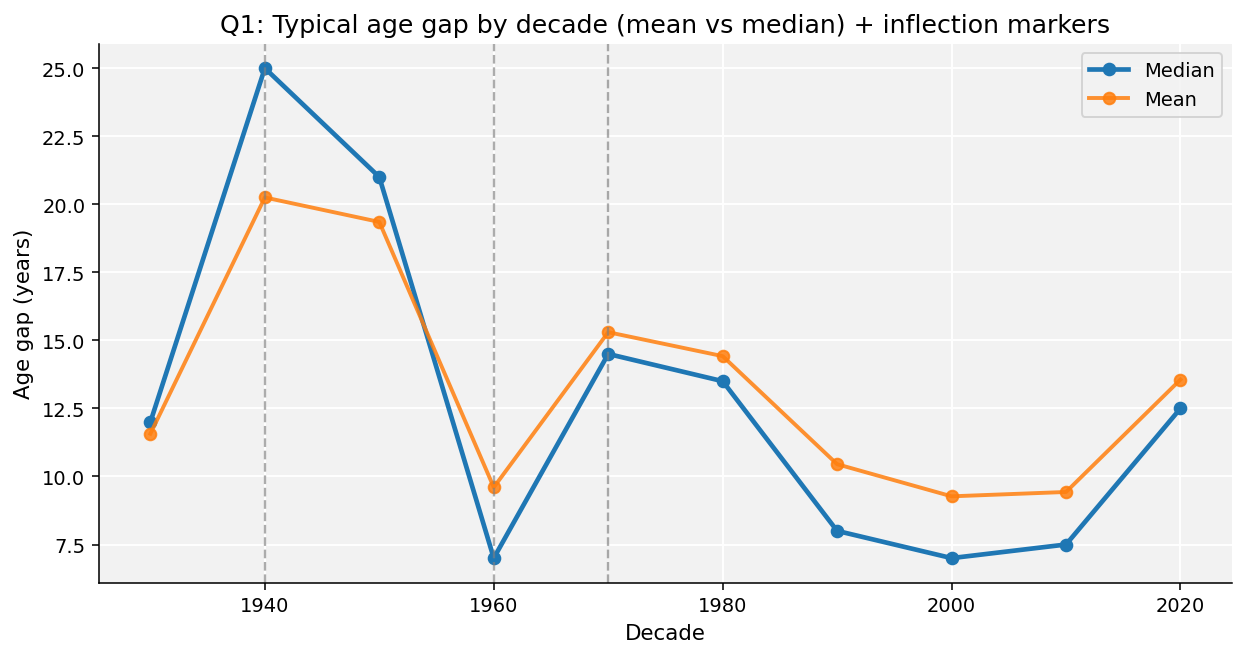


OLS Regression (Q1): age_gap ~ years_since_start

                            OLS Regression Results                            
Dep. Variable:                age_gap   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     50.22
Date:                Thu, 29 Jan 2026   Prob (F-statistic):           2.38e-12
Time:                        00:45:48   Log-Likelihood:                -4087.0
No. Observations:                1155   AIC:                             8178.
Df Residuals:                    1153   BIC:                             8188.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [11]:
decade_stats = (
    df.groupby("decade")
      .agg(
          n_pairs=("age_gap", "size"),
          mean_gap=("age_gap", "mean"),
          median_gap=("age_gap", "median"),
          p_large_gap=("is_large_gap", "mean"),
      )
      .reset_index()
      .sort_values("decade")
)

# Detect inflection points using decade-to-decade changes in median
decade_stats["delta_median"] = decade_stats["median_gap"].diff()
decade_stats["abs_delta_median"] = decade_stats["delta_median"].abs()

inflections = (
    decade_stats.dropna(subset=["abs_delta_median"])
               .sort_values("abs_delta_median", ascending=False)
               .head(3)[["decade", "median_gap", "delta_median", "n_pairs"]]
)

# Make a clean display copy (does NOT change underlying data)
table1 = decade_stats.copy()
table1["p_large_gap"] = (table1["p_large_gap"] * 100).round(1)
table1["mean_gap"] = table1["mean_gap"].round(2)
table1["median_gap"] = table1["median_gap"].round(2)
table1["delta_median"] = table1["delta_median"].round(2)

print("\nTABLE 1 — Decade summary (typical age gap + large-gap share)")
display(table1[["decade", "n_pairs", "mean_gap", "median_gap", "delta_median", "p_large_gap"]])

print("\nTop inflection decades (largest decade-to-decade median changes):")
display(inflections)

# ---- CHART 1: Mean/Median by decade + inflection marker lines
fig, ax = plt.subplots(figsize=(9, 4.8))

ax.plot(table1["decade"], table1["median_gap"], marker="o", linewidth=2.4, label="Median")
ax.plot(table1["decade"], table1["mean_gap"], marker="o", linewidth=2.0, alpha=0.85, label="Mean")

for d in inflections["decade"].tolist():
    ax.axvline(d, linestyle="--", linewidth=1.2, alpha=0.65, color="grey")

ax.set_title("Q1: Typical age gap by decade (mean vs median) + inflection markers")
ax.set_xlabel("Decade")
ax.set_ylabel("Age gap (years)")
ax.legend(frameon=True)

plt.tight_layout()
plt.show()

# ---- OLS model output (trend over time)
m1 = smf.ols("age_gap ~ years_since_start", data=df).fit()
print("\nOLS Regression (Q1): age_gap ~ years_since_start\n")
print(m1.summary())

## QUESTION 2: Do directors cluster into distinct “casting age-gap profiles”, and how stable are those profiles over their careers?


TABLE 2 — Director casting profiles (cluster summaries)


,cluster,n_directors,avg_pairs,mean_gap,median_gap,std_gap,p_large_gap,avg_span
0,0,19,7.9,15.06,14.26,9.91,34.6,19.9
1,1,37,6.4,8.10,6.61,6.11,7.1,12.1


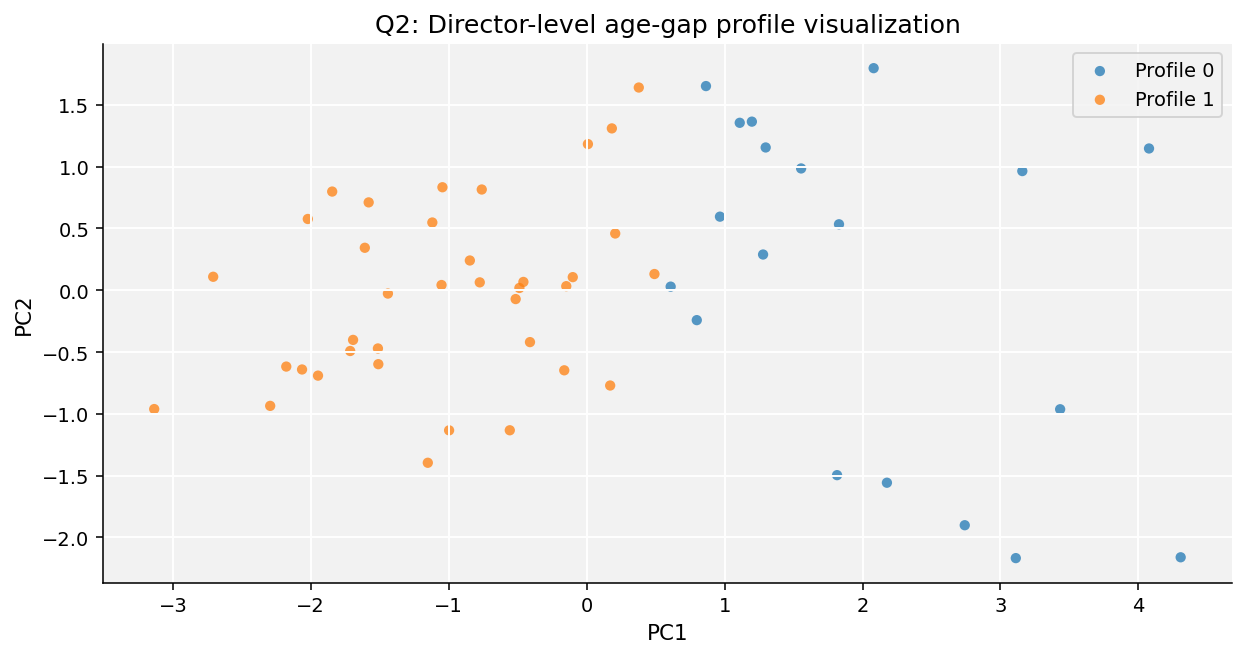


(Extra) Stability summary by cluster (late − early median gap):


/tmp/ipython-input-1154925605.py:107: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(early_late_delta)


,cluster,count,median,mean
0,0,14,-0.25,0.21
1,1,23,2.50,1.72


In [12]:
MIN_COUPLES_PER_DIRECTOR = 5

# ---- Director feature table (one row per director)
dir_feat = (
    df.dropna(subset=["director"])
      .groupby("director")
      .agg(
          n_pairs=("age_gap", "size"),
          mean_gap=("age_gap", "mean"),
          median_gap=("age_gap", "median"),
          std_gap=("age_gap", "std"),
          p_large_gap=("is_large_gap", "mean"),
          first_year=("release_year", "min"),
          last_year=("release_year", "max"),
      )
      .reset_index()
)

# Keep only directors with enough observations for stability
dir_feat = dir_feat[dir_feat["n_pairs"] >= MIN_COUPLES_PER_DIRECTOR].copy()

# Career span feature
dir_feat["career_span"] = dir_feat["last_year"] - dir_feat["first_year"]

# Safety: fill missing proportions
dir_feat["p_large_gap"] = dir_feat["p_large_gap"].fillna(0)

# ---- Clustering features (scaled)
feature_cols = ["mean_gap", "median_gap", "std_gap", "p_large_gap", "career_span"]
X = dir_feat[feature_cols].fillna(0).to_numpy()
Xz = StandardScaler().fit_transform(X)

# Choose k by silhouette score (kept small for interpretability)
k_candidates = range(2, 7)
sil = {}

for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(Xz)
    sil[k] = silhouette_score(Xz, labels)

best_k = max(sil, key=sil.get)

# Fit final model
km = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
dir_feat["cluster"] = km.fit_predict(Xz)

# ---- TABLE 2: Cluster-level summaries for interpretation
cluster_table = (
    dir_feat.groupby("cluster")
            .agg(
                n_directors=("director", "size"),
                avg_pairs=("n_pairs", "mean"),
                mean_gap=("mean_gap", "mean"),
                median_gap=("median_gap", "mean"),
                std_gap=("std_gap", "mean"),
                p_large_gap=("p_large_gap", "mean"),
                avg_span=("career_span", "mean"),
            )
            .reset_index()
)

cluster_table["avg_pairs"] = cluster_table["avg_pairs"].round(1)
cluster_table["mean_gap"] = cluster_table["mean_gap"].round(2)
cluster_table["median_gap"] = cluster_table["median_gap"].round(2)
cluster_table["std_gap"] = cluster_table["std_gap"].round(2)
cluster_table["p_large_gap"] = (cluster_table["p_large_gap"] * 100).round(1)
cluster_table["avg_span"] = cluster_table["avg_span"].round(1)

print("\nTABLE 2 — Director casting profiles (cluster summaries)")
display(cluster_table)

# ---- CHART 2: PCA projection (2D) colored by cluster
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Xz)

dir_feat["pc1"], dir_feat["pc2"] = Z2[:, 0], Z2[:, 1]

fig, ax = plt.subplots(figsize=(9, 4.8))
for c in sorted(dir_feat["cluster"].unique()):
    sub = dir_feat[dir_feat["cluster"] == c]
    ax.scatter(sub["pc1"], sub["pc2"], s=28, alpha=0.75, edgecolors="none", label=f"Profile {c}")

ax.set_title(f"Q2: Director-level age-gap profile visualization")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(frameon=True)

plt.tight_layout()
plt.show()

# ---- Optional: stability metric (late-career median gap - early-career median gap)
def early_late_delta(group):
    mid = np.median(group["release_year"].to_numpy())
    early = group[group["release_year"] <= mid]
    late = group[group["release_year"] > mid]

    if len(early) < 2 or len(late) < 2:
        return np.nan

    return late["age_gap"].median() - early["age_gap"].median()

stability = (
    df.dropna(subset=["director"])
      .merge(dir_feat[["director", "cluster"]], on="director", how="inner")
      .groupby(["director", "cluster"])
      .apply(early_late_delta)
      .reset_index(name="late_minus_early_median_gap")
)

stab_summary = (
    stability.groupby("cluster")["late_minus_early_median_gap"]
             .agg(["count", "median", "mean"])
             .round(2)
             .reset_index()
)

print("\n(Extra) Stability summary by cluster (late − early median gap):")
display(stab_summary)

## QUESTION 3: In multi-couple movies, do age gaps concentrate in one “headline” pairing or appear systematically across couples?



TABLE 3 — Multi-couple movies: within-film dispersion + headline dominance by #couples


,n_couples,n_movies,avg_range,median_range,avg_headline_share,median_headline_share
0,2,156,8.63,6.0,0.731,0.714
1,3,51,12.45,11.0,0.538,0.519
2,4,12,10.83,11.5,0.455,0.426
3,5,3,14.33,9.0,0.413,0.474
4,6,1,15.00,15.0,0.421,0.421
5,7,1,18.00,18.0,0.260,0.260


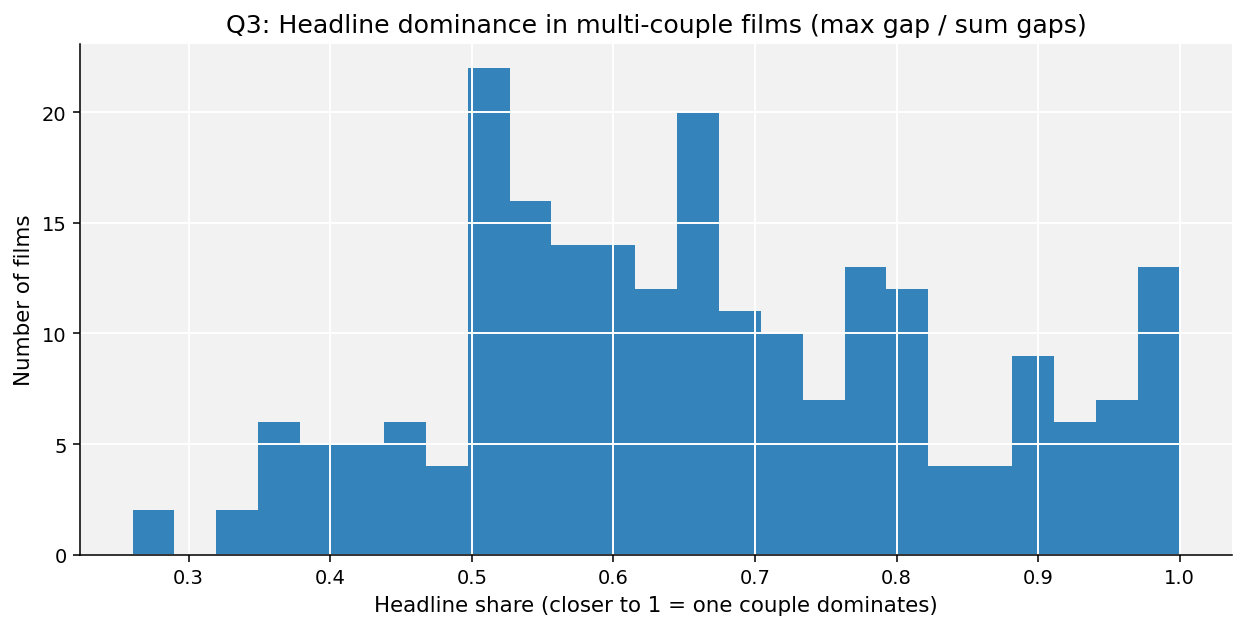

In [13]:
movie_stats = (
    df.groupby(movie_key)
      .agg(
          n_couples=("age_gap", "size"),
          max_gap=("age_gap", "max"),
          min_gap=("age_gap", "min"),
          mean_gap=("age_gap", "mean"),
          std_gap=("age_gap", "std"),
          sum_gap=("age_gap", "sum"),
      )
      .reset_index()
)

# Within-movie dispersion + dominance measures
movie_stats["range_gap"] = movie_stats["max_gap"] - movie_stats["min_gap"]
movie_stats["headline_share"] = movie_stats["max_gap"] / movie_stats["sum_gap"]

multi = movie_stats[movie_stats["n_couples"] > 1].copy()

# ---- TABLE 3: How dispersion + dominance change with number of couples
table3 = (
    multi.groupby("n_couples")
         .agg(
             n_movies=("movie_name", "size"),
             avg_range=("range_gap", "mean"),
             median_range=("range_gap", "median"),
             avg_headline_share=("headline_share", "mean"),
             median_headline_share=("headline_share", "median"),
         )
         .reset_index()
         .sort_values("n_couples")
)

table3["avg_range"] = table3["avg_range"].round(2)
table3["median_range"] = table3["median_range"].round(2)
table3["avg_headline_share"] = table3["avg_headline_share"].round(3)
table3["median_headline_share"] = table3["median_headline_share"].round(3)

print("\nTABLE 3 — Multi-couple movies: within-film dispersion + headline dominance by #couples")
display(table3)

# ---- CHART 3: Distribution of headline dominance
fig, ax = plt.subplots(figsize=(9, 4.6))
ax.hist(multi["headline_share"].dropna(), bins=25, alpha=0.90)

ax.set_title("Q3: Headline dominance in multi-couple films (max gap / sum gaps)")
ax.set_xlabel("Headline share (closer to 1 = one couple dominates)")
ax.set_ylabel("Number of films")

plt.tight_layout()
plt.show()

## QUESTION 4: How do age-gap distributions differ between couple types,and are same-gender pairings closer to age parity?


TABLE 4 — Couple type comparison (Large gap ≥20 yrs, Near parity ≤3 yrs)


,pairing_type,n_pairs,mean_gap,median_gap,p_large_gap,p_near_parity
0,man–woman,929,11.54,10.0,17.4,17.7
1,woman–man,203,5.01,3.0,3.0,53.7
2,man–man,12,15.42,13.5,25.0,16.7
3,woman–woman,11,11.00,8.0,18.2,18.2


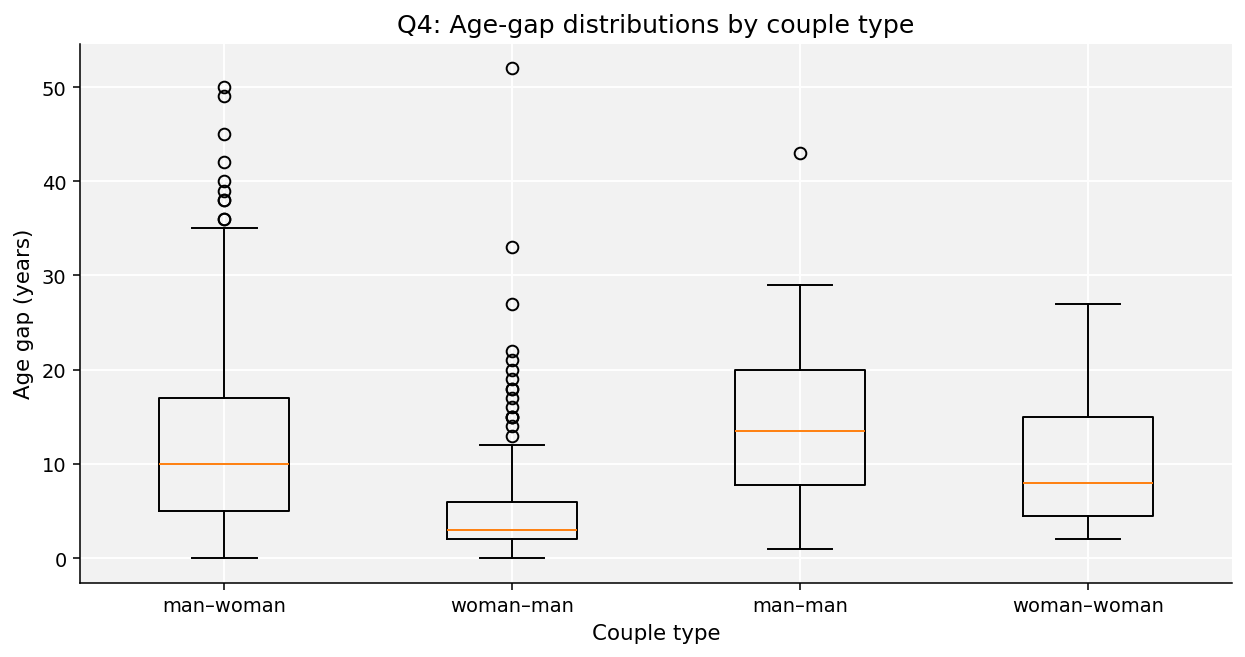

In [14]:
keep_types = ["man–woman", "woman–man", "man–man", "woman–woman"]
df4 = df[df["pairing_type"].isin(keep_types)].copy()

# ---- TABLE 4: Type-level summary + large-gap and parity rates
table4 = (
    df4.groupby("pairing_type")
       .agg(
           n_pairs=("age_gap", "size"),
           mean_gap=("age_gap", "mean"),
           median_gap=("age_gap", "median"),
           p_large_gap=("is_large_gap", "mean"),
           p_near_parity=("is_near_parity", "mean"),
       )
       .reindex(keep_types)
       .reset_index()
)

table4["mean_gap"] = table4["mean_gap"].round(2)
table4["median_gap"] = table4["median_gap"].round(2)
table4["p_large_gap"] = (table4["p_large_gap"] * 100).round(1)
table4["p_near_parity"] = (table4["p_near_parity"] * 100).round(1)

print(f"\nTABLE 4 — Couple type comparison (Large gap ≥{LARGE_GAP} yrs, Near parity ≤{PARITY_CUTOFF} yrs)")
display(table4)

# ---- CHART 4: Boxplot comparison by couple type
type_order = keep_types
box_data = [df4.loc[df4["pairing_type"] == t, "age_gap"].values for t in type_order]

fig, ax = plt.subplots(figsize=(9, 4.8))
ax.boxplot(box_data, tick_labels=type_order, showfliers=True)

ax.set_title("Q4: Age-gap distributions by couple type")
ax.set_xlabel("Couple type")
ax.set_ylabel("Age gap (years)")

plt.tight_layout()
plt.show()